In [1]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy
import tensorflow as tf
from sopt.examples.utils import PtychographySimulation
from sopt.examples.tensorflow.far_field_ptychography.tfPtycho import LMAPhaseRetriever
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

In [2]:
%load_ext autoreload
%autoreload 2

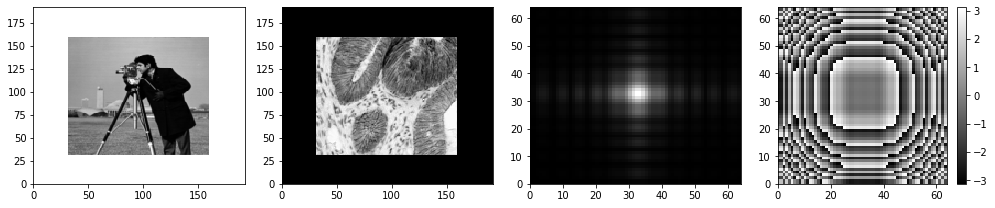

In [3]:
obj_padding_npix = 32
ptsim = PtychographySimulation(obj_npix=128, obj_padding_npix=obj_padding_npix,
                               positions_step_npix=6, probe_n_photons=1e4)

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

In [4]:
ptsim._ndiffs

484

## LMA - reconstructing the object only

In [8]:
pr = LMAPhaseRetriever(ptsim=ptsim, probe_recons=False, validation_ndiffs=50, loss_type="poisson")
pr.setOptimizingParams()
pr.initSession()

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K40c, pci bus id: 0000:04:00.0, compute capability: 3.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [9]:
pr.run(max_iters=200)
pr.data.tail(n=1)

10 -2508995 0.2326382       50 -260490.4 -259575.8
20 -2523622 0.1524539       50 -263783.5 -263723.3
30 -2525170 0.1402805       50 -264209.2 -264189.2
40 -2525523 0.1363397       60 -264356.1 -264334.7
50 -2525672 0.134486       75 -264388.1 -264387.6
60 -2525720 0.1335766       90 -264410.4 -264405.8
70 -2525786 0.1330071      105 -264421.9 -264421.3
80 -2525806 0.1327069      120 -264425.5 -264425.1
90 -2525822 0.1323726      135 -264431.8 -264431.4
100 -2525827 0.1322787      150 -264435.4 -264434.9
110 -2525832 0.1322014      162 -264437.2 -264437.5
120 -2525836 0.1321907      162 -264433.1 -264437.5
130 -2525837 0.1322048      162 -264434.9 -264437.5
140 -2525838 0.1322053      210 -264438.9 -264438.8
150 -2525839 0.1321752      225 -264442.4 -264442.1
160 -2525840 0.1321354      240 -264446.3  -264446
170 -2525842 0.1320937      255 -264449.2 -264448.9
180 -2525844 0.1320424      270 -264457.4  -264457
190 -2525846 0.1320224      285 -264459.5 -264459.5


,loss,epoch,obj_error,probe_error,validation_loss,patience
199,-2525845.5,199.0,0.132019,NaN,-264459.8125,297.0


In [10]:
pr.data.tail(n=5)

,loss,epoch,obj_error,probe_error,validation_loss,patience
195,-2525845.75,195.0,0.132019,NaN,-264459.75000,292.5
196,-2525845.75,196.0,0.132018,NaN,-264459.84375,294.0
197,-2525845.75,197.0,0.132018,NaN,-264459.81250,294.0
198,-2525845.75,198.0,0.132017,NaN,-264459.93750,297.0
199,-2525845.50,199.0,0.132019,NaN,-264459.81250,297.0


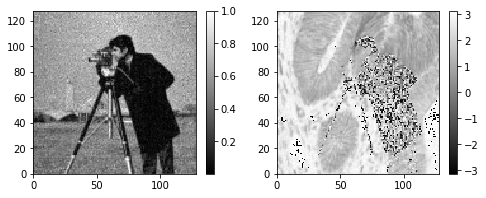

/raid/home/skandel/miniconda3/envs/ad/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


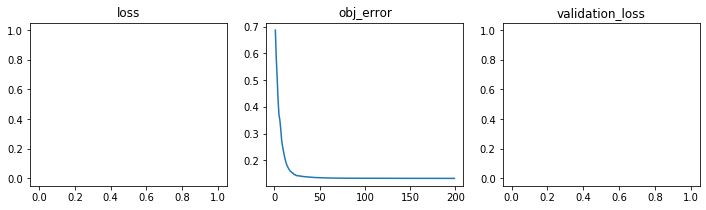

In [11]:
pr.genPlotsRecons()
pr.genPlotMetrics()

In [12]:
with pr.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_lma_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_lma_and_fwd = flops_lma_and_fwd.total_float_ops
    print(f'{flops_lma_and_fwd:4.3g}')

# To calculate the flops required for one conjugate gradient step (within the LMA routine),
# I am isolating the nodes involved in the conjugate gradient calculation.
# Since the conjugate gradient loop is self-contained, we can estimate the cost of
# each cg iteration in this fashion.
graph_def = pr.graph.as_graph_def()
nodes_cg = [node for node in graph_def.node if 'cg_while' in node.name]
flops_cg = get_flops_for_node_list(pr.graph, nodes_cg)

nodes_validation = [node for node in graph_def.node if 'validation' in node.name]
flops_validation = get_flops_for_node_list(pr.graph, nodes_validation)
print(f'flops_cg {flops_cg:4.3g}  flops_validation {flops_validation:4.3g}')

cg_iter_count = pr.session.run(pr._optparams.obj_optimizer._total_cg_iterations)
outer_iterations = pr.data.index[-1] #session.run(opt._iteration)

total_flops = (flops_lma_and_fwd - flops_validation) * outer_iterations + (cg_iter_count - outer_iterations) * flops_cg
print(f'total flops {total_flops:4.3g}')

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
2.65e+09
flops_cg 1.15e+09  flops_validation 2.34e+07
total flops 1.77e+12
